__Input data:__

​To identify the most effective banner in our mobile application, we conducted an A/B test from May 8 to May 9, 2019. The target group was shown a version with a different color scheme, while the control group saw the original design. Both versions offered users the same opportunity to purchase premium features.​

__Task:__

Determine which banner version is more preferred by users in the US region.​

__Data:__

__`Table "Users"`__:
- `UserID` – user identification number;
- `Country` – sales region;
- `Group` – assigned group (control or target)​.

__`Table "Revenue"`__:

- `UserID` – user identification number;
- `Date` – date the user viewed the banner​;
- `Revenue` – revenue generated from the user's purchase of premium features, in BYN​

---

In _A/B testing_, the following metrics are commonly utilized:
- **Conversion Rate (CR)** — the proportion of users who made a purchase (Revenue > 0);
- **Average Revenue Per User (ARPU)** — the average revenue across all users in a group;
- **Average Revenue Per Paying User (ARPPU)** — the average revenue among users who made a purchase.

When selecting the optimal banner variant, it's typically sufficient to focus on:
- Conversion Rate (CR);
- Average Revenue Per User (ARPU);

However, in this dataset, only paying users are included, resulting in a CR of 100% for both groups. A comprehensive A/B test should encompass users who viewed the banner but did not make a purchase. If such users are absent from the dataset (or if Revenue = 0 isn't recorded), the CR assessment may be skewed. Consequently, comparing ARPU becomes meaningless. Therefore, we'll compare the ARPPU between the two groups.

---

**Approaches for Metric Comparison:**
- **Conversion Rates** — a **$\chi^2$-test** is suitable for comparing conversion rates between groups;
- **Revenue Metrics:**
  - If revenues are **uniformly distributed** (lacking heavy tails) and **variance homogeneity** is present, a **two-sample Student's $t$-test** is appropriate. This test examines whether the means of two groups differ in either direction;
  - If revenue distribution is **heavily skewed** with numerous zero values (e.g., many users don't make purchases), **non-parametric tests** like the **Mann-Whitney $U$-test** are recommended. These tests don't assume a specific data distribution and are suitable for analyzing median values;
- **ARPU Evaluation:**
  - Gather revenue data for each user, including those with zero revenue.
  - Apply **bootstrap method** to assess statistical significance without assumptions about data distribution, which is particularly useful in the presence of outliers or asymmetric distributions.

---

**Additional Considerations:**
- With very small samples, the likelihood of erroneous conclusions increases;
- If most users have Revenue = 0, and only a few make purchases, it might be beneficial to extend the experiment's duration or test additional hypotheses;
- If the primary metric (Revenue) isn't reliable for conclusions, consider indirect metrics (e.g., engagement time, clicks).

---

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import boxcox, shapiro, probplot, f, fligner, ttest_ind

In [2]:
sns.set_theme(style='whitegrid')

---

In [3]:
users = pd.read_excel('results.xlsx', sheet_name=1, usecols='A:C', nrows=40000, names=['user_id', 'country', 'group'], dtype={'user_id': np.int_}, keep_default_na=False)
revenue = pd.read_excel('results.xlsx', sheet_name=1, usecols='F:H', nrows=378525, names=['user_id', 'date', 'revenue'], dtype={'user_id': np.int_, 'date': 'datetime64[ns]', 'revenue': np.float_})

In [4]:
start_date = pd.to_datetime('2019-05-08')
end_date = pd.to_datetime('2019-05-09')

In [5]:
users_us = users[users.country == 'US'] 
revenue_ab = revenue[(revenue.date >= start_date) & (revenue.date <= end_date)].drop_duplicates()

ab_test = (pd.merge(users_us[['user_id', 'group']], revenue_ab[['user_id', 'revenue']], on='user_id')).groupby(['user_id', 'group'], as_index=False).sum()
control_group = ab_test.loc[ab_test.group == 'Control', 'revenue']
target_group = ab_test.loc[ab_test.group == 'Target', 'revenue']

In [6]:
print(f'ARPPU of the control group: {control_group.mean():.2f}')
print(f'ARPPU of the target group: {target_group.mean():.2f}')

ARPPU of the control group: 56.81
ARPPU of the target group: 61.86


As our analysis indicates, the **new banner** proved to be **more effective**, yielding an **increase of 5.07 BYN**. Let's statistically validate this hypothesis to ensure the results are not due to chance.

---

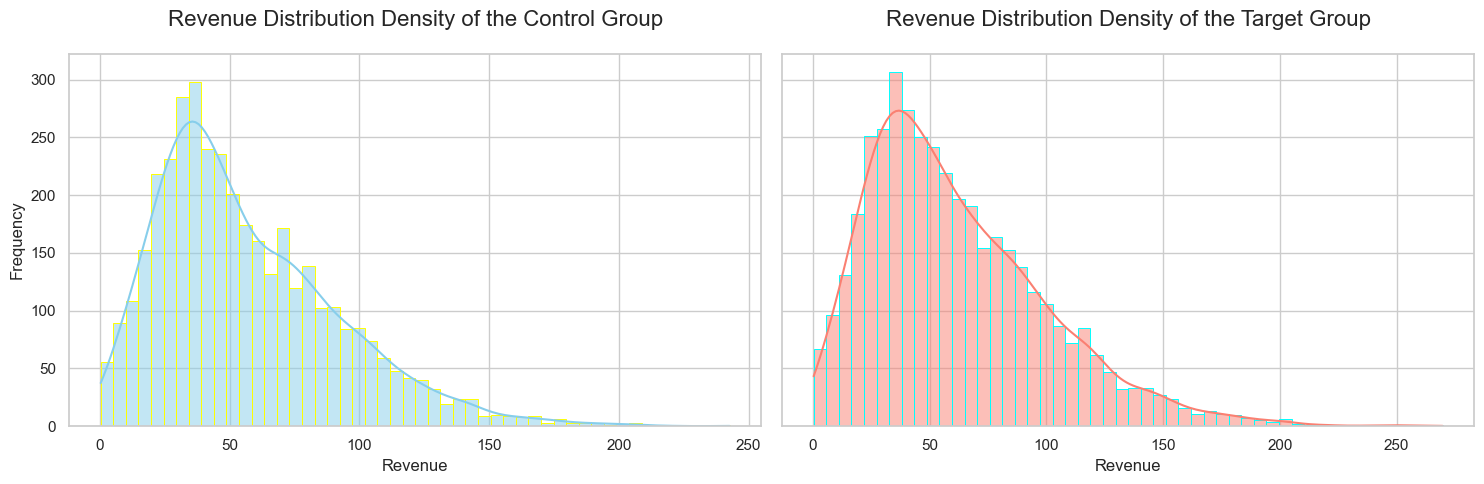

In [7]:
fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), sharey=True)

sns.histplot(control_group, bins=50, kde=True, ax=ax1, color='skyblue', edgecolor='yellow')
sns.histplot(target_group, bins=50, kde=True, ax=ax2, color='salmon', edgecolor='cyan')

ax1.set_xlabel('Revenue', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax2.set_xlabel('Revenue', fontsize=12)
ax2.set_ylabel('')

ax1.set_title('Revenue Distribution Density of the Control Group', fontsize=16, pad=20)
ax2.set_title('Revenue Distribution Density of the Target Group', fontsize=16, pad=20)

plt.tight_layout()
plt.show();

The revenue distribution graphs reveal the following insights:
- Both distributions exhibit a clear right skew. The mode is concentrated around relatively small values, while the tail extends significantly to the right (up to 200-250). This pattern is typical for revenue, where the majority of observations have relatively low values, and a small number of large observations pull the distribution rightward;
- The graphs lack the characteristic bell-shaped form, indicating that the distributions are not approximately normal. Instead, they resemble **log-normal distributions**;
- The right tail of the target group's distribution is slightly more pronounced, suggesting that larger purchases occur more frequently in this group. This observation aligns with the previous numerical finding of a higher ARPPU in the target group.

---

For large samples (approximately 4000 data points in this case), significant skewness isn't necessarily detrimental to parametric tests. According to the **Central Limit Theorem (CLT)**, sample means (and thus the difference between means) can be approximately normally distributed, even if the underlying data isn't. However, with smaller samples, such long tails can severely distort classical parametric results.

In practice, when dealing with revenue data exhibiting such characteristics:
- It's common to apply **logarithmic** or **Box-Cox transformations** to the data. These transformations tend to normalize the distribution, allowing for the use of parametric methods like the **Student's $t$-test** on the transformed data;
- Alternatively, if there's concern that the assumption of normality for the mean isn't met, **non-parametric tests** such as the **Mann-Whitney $U$-test** can be employed. These tests don't assume a specific data distribution and are suitable for analyzing median differences.

To assess the normality of the data, one can utilize **Q–Q plots** or conduct tests like **Shapiro–Wilk**, **Kolmogorov–Smirnov**, **Lilliefors**, or **Anderson–Darling**. These methods help determine the appropriateness of parametric tests for the given dataset.

---

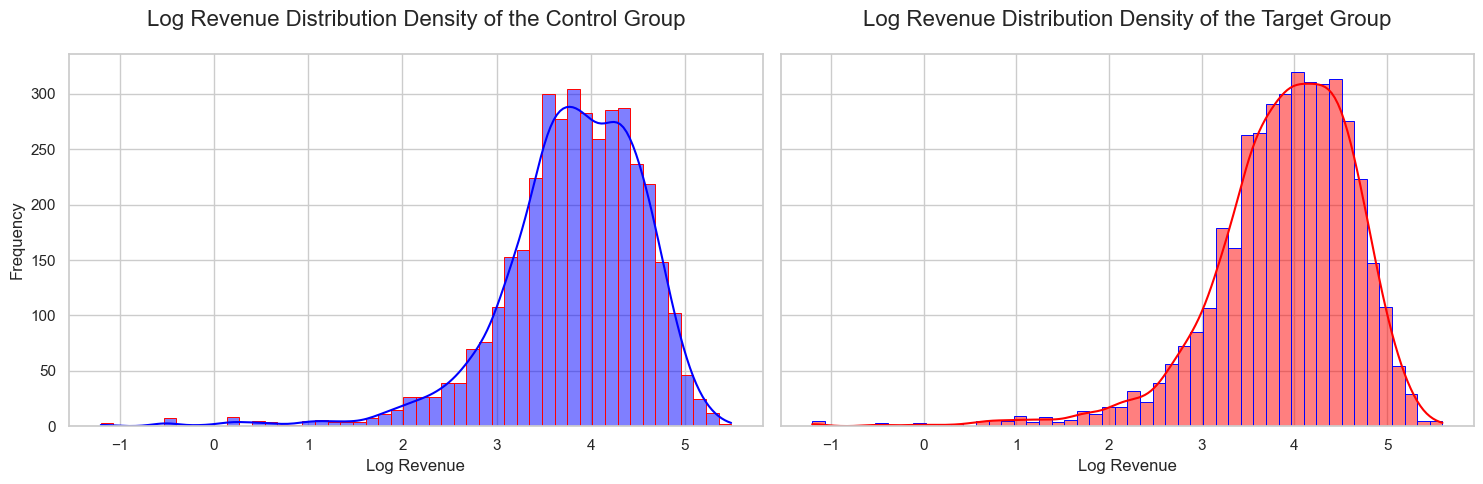

In [8]:
log_control_group = np.log(control_group)
log_target_group = np.log(target_group)

# ----

fig2, (ax3, ax4) = plt.subplots(1, 2, figsize=(15, 5), sharey=True)

sns.histplot(log_control_group, bins=50, kde=True, ax=ax3, color='blue', edgecolor='red')
sns.histplot(log_target_group, bins=50, kde=True, ax=ax4, color='red', edgecolor='blue')

ax3.set_xlabel('Log Revenue', fontsize=12)
ax3.set_ylabel('Frequency', fontsize=12)
ax4.set_xlabel('Log Revenue', fontsize=12)
ax4.set_ylabel('')

ax3.set_title('Log Revenue Distribution Density of the Control Group', fontsize=16, pad=20)
ax4.set_title('Log Revenue Distribution Density of the Target Group', fontsize=16, pad=20)

plt.tight_layout()
plt.show();

Based on the histograms, applying the logarithmic transformation has made the distributions in both groups more symmetrical and closer to normal, enhancing the accuracy of parametric analysis methods.​

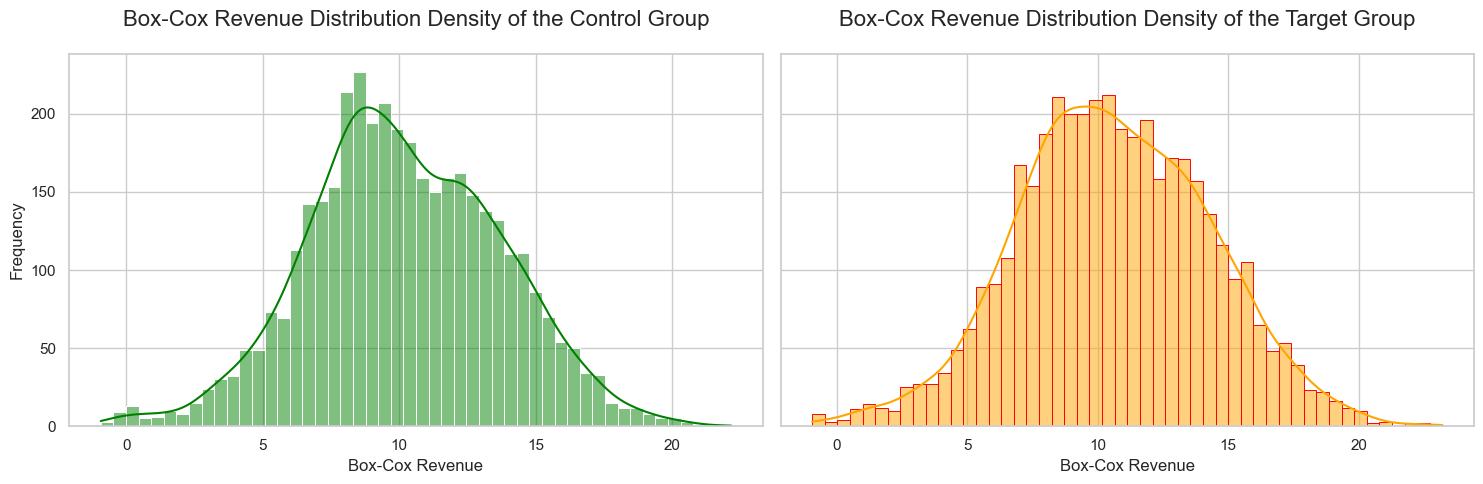

In [9]:
boxcox_control_group, fitted_lambda_cg = boxcox(control_group)
boxcox_target_group, fitted_lambda_tg = boxcox(target_group)

# ----

fig3, (ax5, ax6) = plt.subplots(1, 2, figsize=(15, 5), sharey=True)

sns.histplot(boxcox_control_group, bins=50, kde=True, ax=ax5, color='green', edgecolor='white')
sns.histplot(boxcox_target_group, bins=50, kde=True, ax=ax6, color='orange', edgecolor='red')

ax5.set_xlabel('Box-Cox Revenue', fontsize=12)
ax5.set_ylabel('Frequency', fontsize=12)
ax6.set_xlabel('Box-Cox Revenue', fontsize=12)
ax6.set_ylabel('')

ax5.set_title('Box-Cox Revenue Distribution Density of the Control Group', fontsize=16, pad=20)
ax6.set_title('Box-Cox Revenue Distribution Density of the Target Group', fontsize=16, pad=20)

plt.tight_layout()
plt.show();

After applying the Box-Cox transformation, the distributions in both groups became more symmetrical and closely approximated a normal distribution.​

Shapiro-Wilk test for the control group: 0.9979, p-value: 5.5389e-05
Shapiro-Wilk test for the target group: 0.9988, p-value: 5.0052e-03


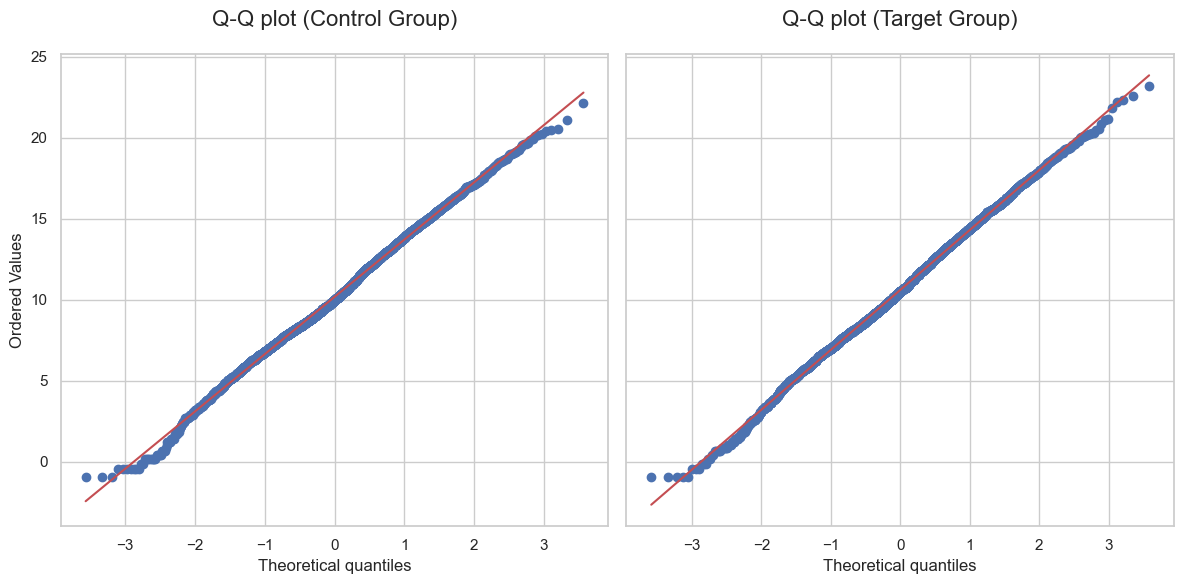

In [10]:
shapiro_stat_cg, p_value_cg = shapiro(boxcox_control_group)
shapiro_stat_tg, p_value_tg = shapiro(boxcox_target_group)

print(f'Shapiro-Wilk test for the control group: {shapiro_stat_cg:.4f}, p-value: {p_value_cg:.4e}')
print(f'Shapiro-Wilk test for the target group: {shapiro_stat_tg:.4f}, p-value: {p_value_tg:.4e}')

# ----

fig4, (ax7, ax8) = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

probplot(boxcox_control_group, dist='norm', plot=ax7)
probplot(boxcox_target_group, dist='norm', plot=ax8)

ax8.set_ylabel('')

ax7.set_title('Q-Q plot (Control Group)', fontsize=16, pad=20)
ax8.set_title('Q-Q plot (Target Group)', fontsize=16, pad=20)

plt.tight_layout()
plt.show();

Despite the **Shapiro-Wilk test** indicating statistically significant deviations from normality (likely due to the large sample size of approximately 4000), **Q-Q plots** suggest that the data for both groups are approximately normal, with only minor deviations at the tails. Therefore, we can consider the data distributions to be approximately normal and proceed with parametric analysis methods, such as the **Student's $t$-test**. However, before applying this test, it's essential to verify another assumption – the **homogeneity of variances** between the groups.

Variance of the control group: 12.514
Variance of the target group: 13.666

F test statistic: 1.092, p-value: 0.006
Fligner–Killeen test statistic: 7.325, p-value: 0.007


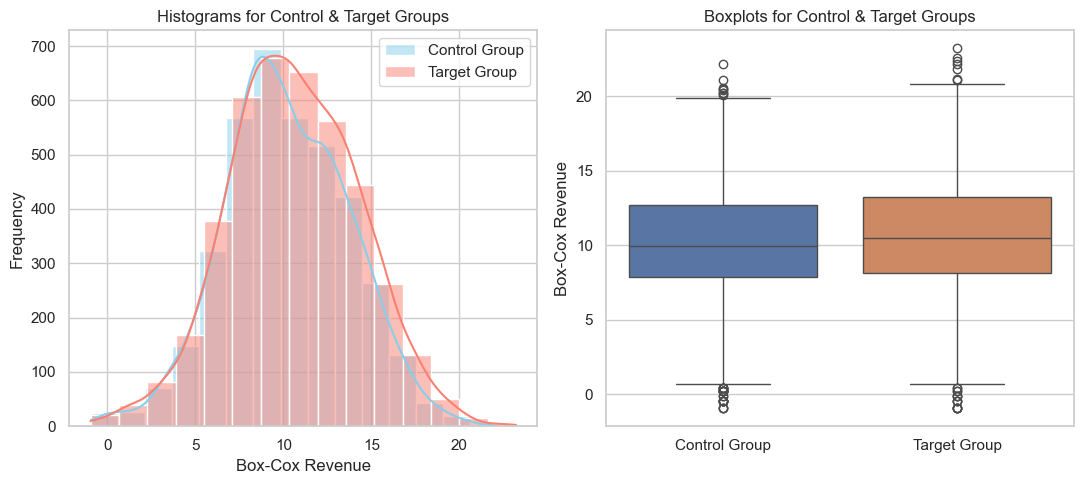

In [11]:
var_cg = np.var(boxcox_control_group, ddof=1)
var_tg = np.var(boxcox_target_group, ddof=1)

print(f'Variance of the control group: {var_cg:.3f}')
print(f'Variance of the target group: {var_tg:.3f}')

if var_cg >= var_tg:
    F_stat = var_cg / var_tg
    dfn = len(boxcox_control_group) - 1
    dfd = len(boxcox_target_group) - 1
else:
    F_stat = var_tg / var_cg
    dfn = len(boxcox_target_group) - 1
    dfd = len(boxcox_control_group) - 1

p_lower = f.cdf(F_stat, dfn, dfd)
p_upper = 1 - p_lower
p_value = 2 * min(p_lower, p_upper)

print(f'\nF test statistic: {F_stat:.3f}, p-value: {p_value:.3f}')

# ----

fk_statistic, p_value = fligner(boxcox_control_group, boxcox_target_group)

print(f'Fligner–Killeen test statistic: {fk_statistic:.3f}, p-value: {p_value:.3f}')

# ----

fig5, (ax9, ax10) = plt.subplots(1, 2, figsize=(11, 5))

sns.histplot(boxcox_control_group, bins=15, ax=ax9, kde=True, color='skyblue', label='Control Group')
sns.histplot(boxcox_target_group, bins=15, ax=ax9, kde=True, color='salmon', label='Target Group')

ax9.legend()
ax9.set_title('Histograms for Control & Target Groups')
ax9.set_xlabel('Box-Cox Revenue')
ax9.set_ylabel('Frequency')

sns.boxplot(data=[boxcox_control_group, boxcox_target_group])

ax10.set_xticks([0, 1], ['Control Group', 'Target Group'])
ax10.set_title('Boxplots for Control & Target Groups')
ax10.set_ylabel('Box-Cox Revenue')

plt.tight_layout()
plt.show();

Both **Fisher's test** (which assumes normality and no deviations) and the **Fligner–Killeen test** (which doesn't require normality and is robust to outliers) indicate statistically significant differences in variances ($p$-value < 0.01), despite the variances being numerically close. This is due to the large sample size (approximately 4000 observations), where even minor deviations become statistically significant. In practice, such a difference in variances can be considered negligible. Therefore, for further analysis (in this case, comparing means), we'll use a test that doesn't require equal variances—the **Welch's $t$-test**.

In [12]:
tw_statistic, p_value = ttest_ind(boxcox_target_group, boxcox_control_group, equal_var=False)
print(f'Welch test statistic: {tw_statistic:.3f}, p-value: {p_value:.12f}')

Welch test statistic: 5.216, p-value: 0.000000187337


__The Welch's $t$-test__ revealed a statistically significant difference between the control and test groups $(p \approx 1.87 \times 10^{-8})$. The positive t-statistic value (5.216) indicates that the test banner led to a substantially higher average revenue. __This suggests that the change in color scheme positively influenced user behavior and can be recommended for implementation__.​